# PK/PD AL Model Calibration

## Calibrating PK/PD Model to output AL Efficacy = 0.965 or 96.5% for weight = 54 Kg

<br>

In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

<br>

### Experiment Number: 2

In [30]:
# Setting min and max values for EC50_artemether and pmax_artemether
min_ec50 = 33.31
max_ec50 = 93.31

min_pmax = 0.999
max_pmax = 0.9999

# Define the range for EC50 and pmax
ec50_values = np.linspace(min_ec50, max_ec50, 25)
pmax_values = np.linspace(min_pmax, max_pmax, 25)

#Saving EC50_artemether and pmax_artemether range for future reference
experiment = "01"
folder = f"AL_calibration_heatmap_results_{experiment}"
os.makedirs(folder, exist_ok=True) 

np.savetxt(f'{folder}/AL_calibration_heatmap_pmax_lum_range_{experiment}.txt', pmax_values, delimiter=',', fmt='%5f')
np.savetxt(f'{folder}/AL_calibratione_heatmap_ec50_lum_range_{experiment}.txt', ec50_values, delimiter=',', fmt='%5f')

# Create a meshgrid for all combinations
ec50_grid, pmax_grid = np.meshgrid(ec50_values, pmax_values)
trial_efficacy = np.zeros(ec50_grid.shape)

# Flatten the grids for parallel processing
ec50_flat = ec50_grid.flatten()
pmax_flat = pmax_grid.flatten()

#Checking pmax_artemether, ec50_artemether by eye
print("pmax_artemether Range: ",pmax_values)
print("EC50_artemether Range: ",ec50_values)

pmax_artemether Range:  [0.999     0.9990375 0.999075  0.9991125 0.99915   0.9991875 0.999225
 0.9992625 0.9993    0.9993375 0.999375  0.9994125 0.99945   0.9994875
 0.999525  0.9995625 0.9996    0.9996375 0.999675  0.9997125 0.99975
 0.9997875 0.999825  0.9998625 0.9999   ]
EC50_artemether Range:  [33.31 35.81 38.31 40.81 43.31 45.81 48.31 50.81 53.31 55.81 58.31 60.81
 63.31 65.81 68.31 70.81 73.31 75.81 78.31 80.81 83.31 85.81 88.31 90.81
 93.31]


In [31]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

# Function to run a single simulation for a given (ec50, pmax) pair
def run_simulation(params):
    i, j, ec50, pmax = params

    command_ec50_pmax_lum = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "100",
        "--pmax_lum", str(pmax),
        "--ec50_lum", str(ec50),
        "--pmax_artemether", "0.9998653531",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_ec50_pmax_lum = subprocess.run(command_ec50_pmax_lum, capture_output=True, text=True, check=True)

        # Process the output
        lines_ec50_pmax_lum = output_ec50_pmax_lum.stdout.splitlines()
        df_ec50_pmax_lum = pd.DataFrame(
            [line.split() for line in lines_ec50_pmax_lum],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_ec50_pmax_lum = df_ec50_pmax_lum.iloc[1:].apply(pd.to_numeric, errors='coerce')

        experiment = "01"
        folder = f"AL_calibration_heatmap_results_{experiment}"
        os.makedirs(folder, exist_ok=True)  # Creates folder if it doesn't exist

        # Saving the Dataframe as a CSV file 
        filepath = f"{folder}/AL_calibration_heatmap_lum_pmax_{pmax:.2f}_ec50_{ec50:.2f}.csv"
        df_ec50_pmax_lum.to_csv(filepath, index=False)

        # Calculate the efficacy
        # Here the hour filter is just to make sure the data is as expected

        failed_treatment_count = df_ec50_pmax_lum[(df_ec50_pmax_lum['PARASITEDENSITY'] >= 10) & (df_ec50_pmax_lum['HOUR'] == 671.0)].shape[0]
        total_patients = df_ec50_pmax_lum['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        # Output the failed treatment count for each pmax-EC50 pair as a text file
        # Naming the text file with the pmax-EC50 pair

        filepath = f"{folder}/AL_calibration_heatmap_lum_pmax_{pmax:.2f}_ec50_{ec50:.2f}.txt"

        with open(filepath, "w") as f:
            f.write(f"pmax_lum: {pmax}, EC50_lum: {ec50}, Failed treatment count: {failed_treatment_count}\n")

        return (i, j, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for EC50: {ec50}, pmax: {pmax}: {e}")
        return (i, j, np.nan)  # Return NaN in case of failure

In [32]:
# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, j, ec50_flat[i * len(pmax_values) + j], pmax_flat[i * len(pmax_values) + j])
               for i in range(len(ec50_values)) for j in range(len(pmax_values))]

# Run simulations in parallel
with Pool(processes=num_workers) as pool:
    # Use tqdm to track the progress of the parallel tasks
    results = list(tqdm(pool.imap(run_simulation, params_list), total=len(params_list)))

# Update the efficacy grid with the results
for i, j, efficacy in results:
    trial_efficacy[i, j] = efficacy

# Create a DataFrame from the efficacy grid
df_trial_efficacy = pd.DataFrame(trial_efficacy, index=pmax_values, columns=ec50_values)


experiment = "01"
folder = f"AL_calibration_heatmap_results_{experiment}"
# Save the DataFrame to a CSV file
df_trial_efficacy.to_csv(f"{folder}/AL_calibration_heatmap_lum_{experiment}.csv")

# Save the DataFrame to a pickle file
df_trial_efficacy.to_pickle(f"{folder}/AL_calibration_heatmap_lum_{experiment}.pyobj")
print("Parallel simulation completed and results saved in CSV and pickle formats.")

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")


100%|██████████| 625/625 [03:06<00:00,  3.36it/s]

Parallel simulation completed and results saved in CSV and pickle formats.

Today's date:  2025-06-06 

Length of simulation:  0:03:08.722705 



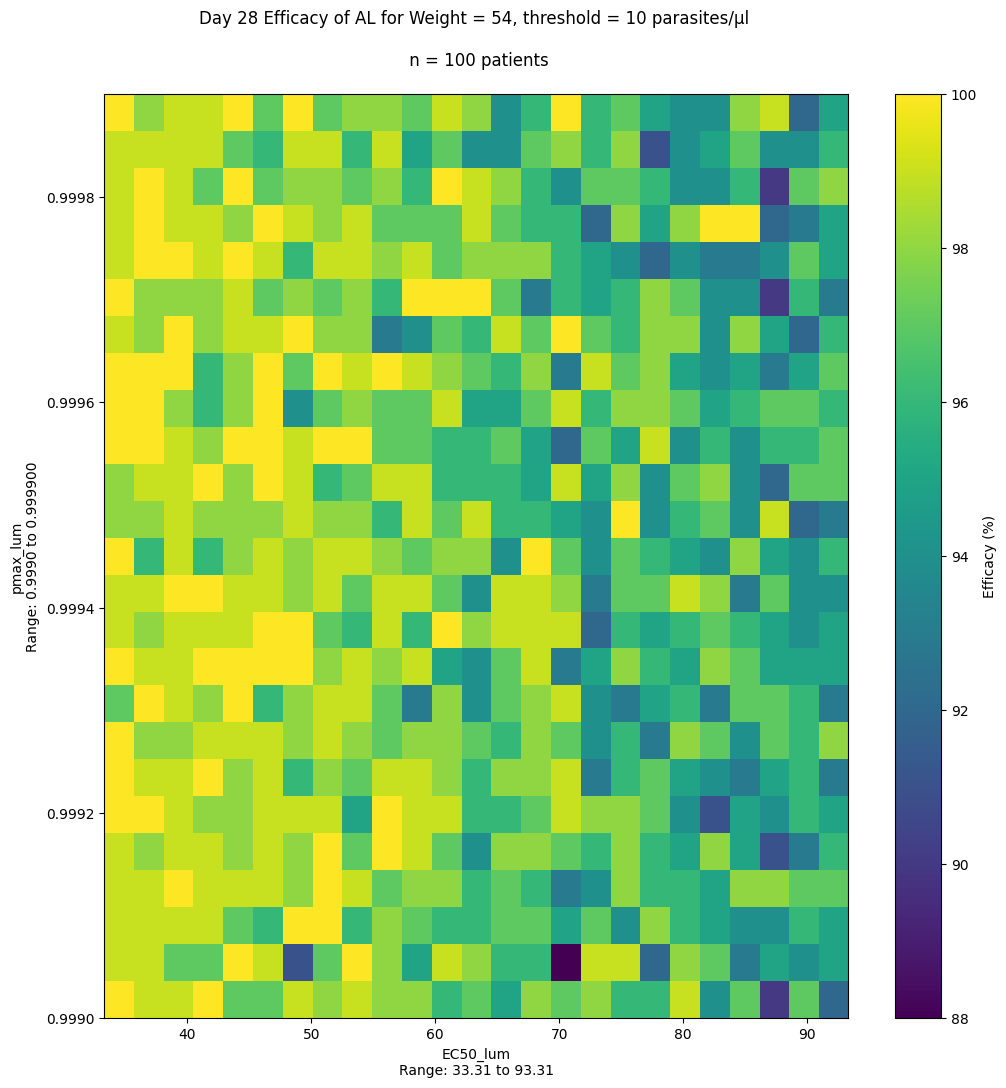

In [33]:
plt.figure(figsize=(12, 12))

plt.imshow(df_trial_efficacy, extent=(min_ec50, max_ec50, min_pmax, max_pmax), origin='lower', cmap='viridis', aspect = 'auto')

# Create the colorbar
plt.colorbar(label='Efficacy (%)')

# Set the labels and title
plt.xlabel('EC50_lum\nRange: {:.2f} to {:.2f}'.format(min_ec50, max_ec50))
plt.ylabel('pmax_lum\nRange: {:.4f} to {:.6f}'.format(min_pmax, max_pmax))
plt.title('Day 28 Efficacy of AL for Weight = 54, threshold = 10 parasites/μl \n\n n = 100 patients\n')

experiment = "01"
folder = f"AL_calibration_heatmap_results_{experiment}"
#Save plot
plt.savefig(f"{folder}/AL_calibration_heatmap_results_{experiment}.png")
# Show the plot
plt.show()

<br>

### Experiment Number: 02

In [34]:
# Setting min and max values for EC50_artemether and pmax_artemether
min_ec50 = 33.31
max_ec50 = 93.31

min_pmax = 0.999
max_pmax = 0.9999

# Define the range for EC50 and pmax
ec50_values = np.linspace(min_ec50, max_ec50, 50)
pmax_values = np.linspace(min_pmax, max_pmax, 50)

#Saving EC50_artemether and pmax_artemether range for future reference
experiment = "02"
folder = f"AL_calibration_heatmap_results_{experiment}"
os.makedirs(folder, exist_ok=True) 

np.savetxt(f'{folder}/AL_calibration_heatmap_pmax_lum_range_{experiment}.txt', pmax_values, delimiter=',', fmt='%5f')
np.savetxt(f'{folder}/AL_calibratione_heatmap_ec50_lum_range_{experiment}.txt', ec50_values, delimiter=',', fmt='%5f')

# Create a meshgrid for all combinations
ec50_grid, pmax_grid = np.meshgrid(ec50_values, pmax_values)
trial_efficacy = np.zeros(ec50_grid.shape)

# Flatten the grids for parallel processing
ec50_flat = ec50_grid.flatten()
pmax_flat = pmax_grid.flatten()

#Checking pmax_artemether, ec50_artemether by eye
print("pmax_artemether Range: ",pmax_values)
print("EC50_artemether Range: ",ec50_values)

pmax_artemether Range:  [0.999      0.99901837 0.99903673 0.9990551  0.99907347 0.99909184
 0.9991102  0.99912857 0.99914694 0.99916531 0.99918367 0.99920204
 0.99922041 0.99923878 0.99925714 0.99927551 0.99929388 0.99931224
 0.99933061 0.99934898 0.99936735 0.99938571 0.99940408 0.99942245
 0.99944082 0.99945918 0.99947755 0.99949592 0.99951429 0.99953265
 0.99955102 0.99956939 0.99958776 0.99960612 0.99962449 0.99964286
 0.99966122 0.99967959 0.99969796 0.99971633 0.99973469 0.99975306
 0.99977143 0.9997898  0.99980816 0.99982653 0.9998449  0.99986327
 0.99988163 0.9999    ]
EC50_artemether Range:  [33.31       34.5344898  35.75897959 36.98346939 38.20795918 39.43244898
 40.65693878 41.88142857 43.10591837 44.33040816 45.55489796 46.77938776
 48.00387755 49.22836735 50.45285714 51.67734694 52.90183673 54.12632653
 55.35081633 56.57530612 57.79979592 59.02428571 60.24877551 61.47326531
 62.6977551  63.9222449  65.14673469 66.37122449 67.59571429 68.82020408
 70.04469388 71.26918367 72

In [37]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

# Function to run a single simulation for a given (ec50, pmax) pair
def run_simulation(params):
    i, j, ec50, pmax = params

    command_ec50_pmax_lum = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "500",
        "--pmax_lum", str(pmax),
        "--ec50_lum", str(ec50),
        "--pmax_artemether", "0.9998653531",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_ec50_pmax_lum = subprocess.run(command_ec50_pmax_lum, capture_output=True, text=True, check=True)

        # Process the output
        lines_ec50_pmax_lum = output_ec50_pmax_lum.stdout.splitlines()
        df_ec50_pmax_lum = pd.DataFrame(
            [line.split() for line in lines_ec50_pmax_lum],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_ec50_pmax_lum = df_ec50_pmax_lum.iloc[1:].apply(pd.to_numeric, errors='coerce')

        experiment = "02"
        folder = f"AL_calibration_heatmap_results_{experiment}"
        os.makedirs(folder, exist_ok=True)  # Creates folder if it doesn't exist

        # Saving the Dataframe as a CSV file 
        filepath = f"{folder}/AL_calibration_heatmap_lum_pmax_{pmax:.2f}_ec50_{ec50:.2f}.csv"
        df_ec50_pmax_lum.to_csv(filepath, index=False)

        # Calculate the efficacy
        # Here the hour filter is just to make sure the data is as expected

        failed_treatment_count = df_ec50_pmax_lum[(df_ec50_pmax_lum['PARASITEDENSITY'] >= 10) & (df_ec50_pmax_lum['HOUR'] == 671.0)].shape[0]
        total_patients = df_ec50_pmax_lum['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        # Output the failed treatment count for each pmax-EC50 pair as a text file
        # Naming the text file with the pmax-EC50 pair

        filepath = f"{folder}/AL_calibration_heatmap_lum_pmax_{pmax:.2f}_ec50_{ec50:.2f}.txt"

        with open(filepath, "w") as f:
            f.write(f"pmax_lum: {pmax}, EC50_lum: {ec50}, Failed treatment count: {failed_treatment_count}\n")

        return (i, j, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for EC50: {ec50}, pmax: {pmax}: {e}")
        return (i, j, np.nan)  # Return NaN in case of failure

In [38]:
# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, j, ec50_flat[i * len(pmax_values) + j], pmax_flat[i * len(pmax_values) + j])
               for i in range(len(ec50_values)) for j in range(len(pmax_values))]

# Run simulations in parallel
with Pool(processes=num_workers) as pool:
    # Use tqdm to track the progress of the parallel tasks
    results = list(tqdm(pool.imap(run_simulation, params_list), total=len(params_list)))

# Update the efficacy grid with the results
for i, j, efficacy in results:
    trial_efficacy[i, j] = efficacy

# Create a DataFrame from the efficacy grid
df_trial_efficacy = pd.DataFrame(trial_efficacy, index=pmax_values, columns=ec50_values)


experiment = "02"
folder = f"AL_calibration_heatmap_results_{experiment}"
# Save the DataFrame to a CSV file
df_trial_efficacy.to_csv(f"{folder}/AL_calibration_heatmap_lum_{experiment}.csv")

# Save the DataFrame to a pickle file
df_trial_efficacy.to_pickle(f"{folder}/AL_calibration_heatmap_lum_{experiment}.pyobj")
print("Parallel simulation completed and results saved in CSV and pickle formats.")

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")


100%|██████████| 2500/2500 [1:01:22<00:00,  1.47s/it]

Parallel simulation completed and results saved in CSV and pickle formats.

Today's date:  2025-06-06 

Length of simulation:  1:01:24.718146 



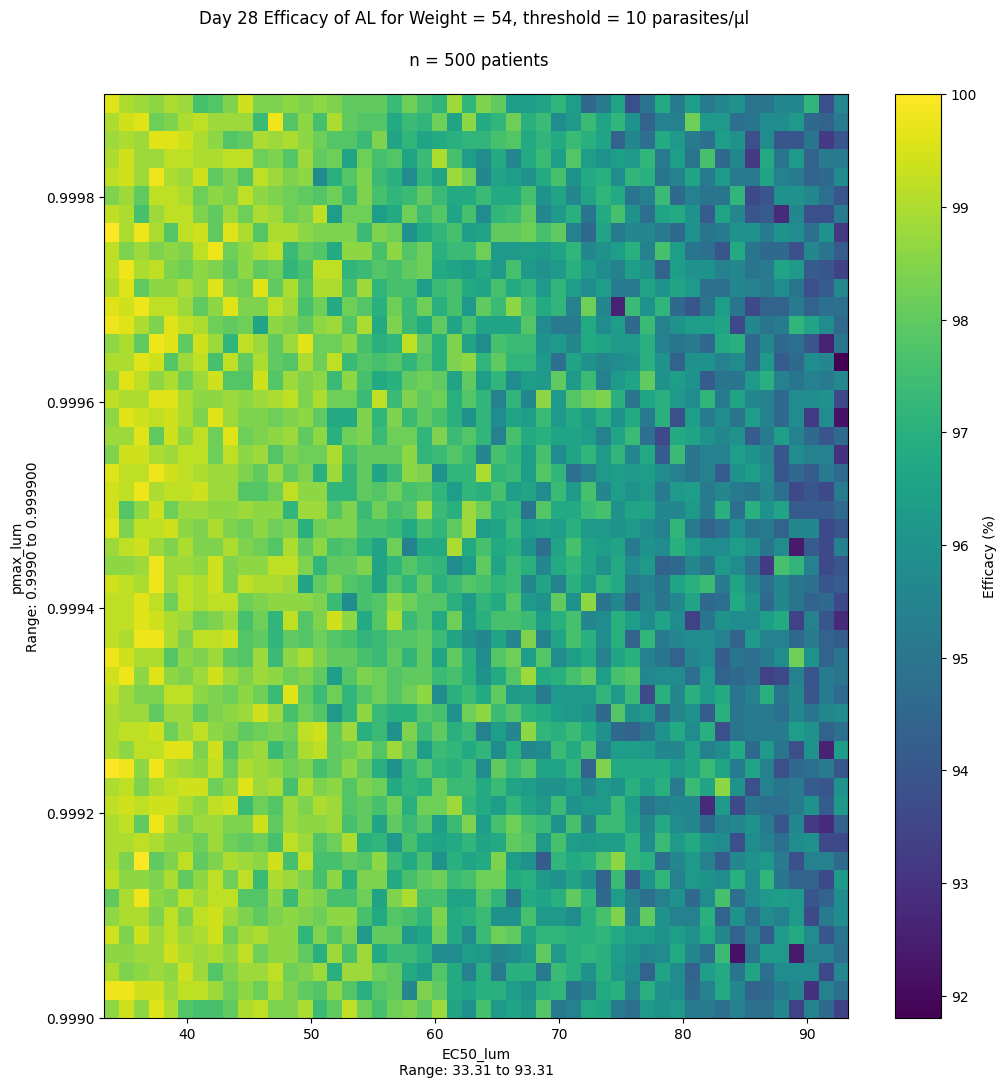

In [39]:

plt.figure(figsize=(12, 12))

plt.imshow(df_trial_efficacy, extent=(min_ec50, max_ec50, min_pmax, max_pmax), origin='lower', cmap='viridis', aspect = 'auto')

# Create the colorbar
plt.colorbar(label='Efficacy (%)')

# Set the labels and title
plt.xlabel('EC50_lum\nRange: {:.2f} to {:.2f}'.format(min_ec50, max_ec50))
plt.ylabel('pmax_lum\nRange: {:.4f} to {:.6f}'.format(min_pmax, max_pmax))
plt.title('Day 28 Efficacy of AL for Weight = 54, threshold = 10 parasites/μl \n\n n = 500 patients\n')

experiment = "02"
folder = f"AL_calibration_heatmap_results_{experiment}"
#Save plot
plt.savefig(f"{folder}/AL_calibration_heatmap_results_{experiment}.png")
# Show the plot
plt.show()

In [40]:
for i in range(len(ec50_values)):
    for j in range(len(pmax_values)):
        print(f"EC50: {ec50_values[i]:.2f}, pmax: {pmax_values[j]:.6f}, Efficacy: {df_trial_efficacy.iloc[i, j]:.2f}%")
    #Save in one text file
        with open(f"{folder}/AL_calibration_heatmap_{experiment}_results.txt", "a") as f:
            f.write(f"EC50: {ec50_values[i]:.2f}, pmax: {pmax_values[j]:.6f}, Efficacy: {df_trial_efficacy.iloc[i, j]:.2f}%\n")
    # Save in one dataframe and then save as csv
df_results = pd.DataFrame({
    'EC50_lum': np.repeat(ec50_values, len(pmax_values)),
    'pmax_lum': np.tile(pmax_values, len(ec50_values)),
    'Efficacy': df_trial_efficacy.values.flatten()
})
df_results.to_csv(f"{folder}/AL_calibration_heatmap_{experiment}_results.csv", index=False)

EC50: 33.31, pmax: 0.999000, Efficacy: 98.60%
EC50: 33.31, pmax: 0.999018, Efficacy: 99.40%
EC50: 33.31, pmax: 0.999037, Efficacy: 98.60%
EC50: 33.31, pmax: 0.999055, Efficacy: 99.60%
EC50: 33.31, pmax: 0.999073, Efficacy: 99.00%
EC50: 33.31, pmax: 0.999092, Efficacy: 97.80%
EC50: 33.31, pmax: 0.999110, Efficacy: 97.60%
EC50: 33.31, pmax: 0.999129, Efficacy: 97.60%
EC50: 33.31, pmax: 0.999147, Efficacy: 98.00%
EC50: 33.31, pmax: 0.999165, Efficacy: 99.00%
EC50: 33.31, pmax: 0.999184, Efficacy: 99.20%
EC50: 33.31, pmax: 0.999202, Efficacy: 98.40%
EC50: 33.31, pmax: 0.999220, Efficacy: 98.40%
EC50: 33.31, pmax: 0.999239, Efficacy: 99.00%
EC50: 33.31, pmax: 0.999257, Efficacy: 97.40%
EC50: 33.31, pmax: 0.999276, Efficacy: 98.00%
EC50: 33.31, pmax: 0.999294, Efficacy: 99.20%
EC50: 33.31, pmax: 0.999312, Efficacy: 98.20%
EC50: 33.31, pmax: 0.999331, Efficacy: 97.60%
EC50: 33.31, pmax: 0.999349, Efficacy: 98.20%
EC50: 33.31, pmax: 0.999367, Efficacy: 98.40%
EC50: 33.31, pmax: 0.999386, Effic

In [44]:
filtered_results = df_results[(df_results['Efficacy'] > 96.4) & (df_results['Efficacy'] <= 96.6)]
filtered_results

,EC50_lum,pmax_lum,Efficacy
23,33.31000,0.999422,96.6
27,33.31000,0.999496,96.6
33,33.31000,0.999606,96.6
74,34.53449,0.999441,96.6
137,35.75898,0.999680,96.6
...,...,...,...
2383,90.86102,0.999606,96.6
2423,92.08551,0.999422,96.6
2433,92.08551,0.999606,96.6
2479,93.31000,0.999533,96.6


<br>

### Experiment Number: 03

In [26]:
# Setting min and max values for EC50_lum and pmax_lum
min_ec50 = 33.31
max_ec50 = 93.31

min_pmax = 0.999
max_pmax = 0.9999

# Define the range for EC50 and pmax
ec50_values = np.linspace(min_ec50, max_ec50, 100)
pmax_values = np.linspace(min_pmax, max_pmax, 100)

#Saving EC50_lum and pmax_lum range for future reference
experiment = "03"
folder = f"AL_calibration_heatmap_results_{experiment}"
os.makedirs(folder, exist_ok=True) 

np.savetxt(f'{folder}/AL_calibration_heatmap_pmax_lum_range_{experiment}.txt', pmax_values, delimiter=',', fmt='%5f')
np.savetxt(f'{folder}/AL_calibratione_heatmap_ec50_lum_range_{experiment}.txt', ec50_values, delimiter=',', fmt='%5f')

# Create a meshgrid for all combinations
ec50_grid, pmax_grid = np.meshgrid(ec50_values, pmax_values)
trial_efficacy = np.zeros(ec50_grid.shape)

# Flatten the grids for parallel processing
ec50_flat = ec50_grid.flatten()
pmax_flat = pmax_grid.flatten()

#Checking pmax_lum, ec50_lum by eye
print("pmax_lum Range: ",pmax_values)
print("EC50_lum Range: ",ec50_values)

pmax_lum Range:  [0.999      0.99900909 0.99901818 0.99902727 0.99903636 0.99904545
 0.99905455 0.99906364 0.99907273 0.99908182 0.99909091 0.9991
 0.99910909 0.99911818 0.99912727 0.99913636 0.99914545 0.99915455
 0.99916364 0.99917273 0.99918182 0.99919091 0.9992     0.99920909
 0.99921818 0.99922727 0.99923636 0.99924545 0.99925455 0.99926364
 0.99927273 0.99928182 0.99929091 0.9993     0.99930909 0.99931818
 0.99932727 0.99933636 0.99934545 0.99935455 0.99936364 0.99937273
 0.99938182 0.99939091 0.9994     0.99940909 0.99941818 0.99942727
 0.99943636 0.99944545 0.99945455 0.99946364 0.99947273 0.99948182
 0.99949091 0.9995     0.99950909 0.99951818 0.99952727 0.99953636
 0.99954545 0.99955455 0.99956364 0.99957273 0.99958182 0.99959091
 0.9996     0.99960909 0.99961818 0.99962727 0.99963636 0.99964545
 0.99965455 0.99966364 0.99967273 0.99968182 0.99969091 0.9997
 0.99970909 0.99971818 0.99972727 0.99973636 0.99974545 0.99975455
 0.99976364 0.99977273 0.99978182 0.99979091 0.9998  

In [27]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

# Function to run a single simulation for a given (ec50, pmax) pair
def run_simulation(params):
    i, j, ec50, pmax = params

    command_ec50_pmax_lum = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "500",
        "--pmax_lum", str(pmax),
        "--ec50_lum", str(ec50),
        "--pmax_artemether", "0.9998619",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_ec50_pmax_lum = subprocess.run(command_ec50_pmax_lum, capture_output=True, text=True, check=True)

        # Process the output
        lines_ec50_pmax_lum = output_ec50_pmax_lum.stdout.splitlines()
        df_ec50_pmax_lum = pd.DataFrame(
            [line.split() for line in lines_ec50_pmax_lum],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_ec50_pmax_lum = df_ec50_pmax_lum.iloc[1:].apply(pd.to_numeric, errors='coerce')

        experiment = "03"
        folder = f"AL_calibration_heatmap_results_{experiment}"
        os.makedirs(folder, exist_ok=True)  # Creates folder if it doesn't exist

        # Saving the Dataframe as a CSV file 
        filepath = f"{folder}/AL_calibration_heatmap_lum_pmax_{pmax:.2f}_ec50_{ec50:.2f}.csv"
        df_ec50_pmax_lum.to_csv(filepath, index=False)

        # Calculate the efficacy
        # Here the hour filter is just to make sure the data is as expected

        failed_treatment_count = df_ec50_pmax_lum[(df_ec50_pmax_lum['PARASITEDENSITY'] >= 10) & (df_ec50_pmax_lum['HOUR'] == 671.0)].shape[0]
        total_patients = df_ec50_pmax_lum['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        # Output the failed treatment count for each pmax-EC50 pair as a text file
        # Naming the text file with the pmax-EC50 pair

        filepath = f"{folder}/AL_calibration_heatmap_lum_pmax_{pmax:.2f}_ec50_{ec50:.2f}.txt"

        with open(filepath, "w") as f:
            f.write(f"pmax_lum: {pmax}, EC50_lum: {ec50}, Failed treatment count: {failed_treatment_count}\n")

        return (i, j, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for EC50: {ec50}, pmax: {pmax}: {e}")
        return (i, j, np.nan)  # Return NaN in case of failure

In [28]:
# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, j, ec50_flat[i * len(pmax_values) + j], pmax_flat[i * len(pmax_values) + j])
               for i in range(len(ec50_values)) for j in range(len(pmax_values))]

# Run simulations in parallel
with Pool(processes=num_workers) as pool:
    # Use tqdm to track the progress of the parallel tasks
    results = list(tqdm(pool.imap(run_simulation, params_list), total=len(params_list)))

# Update the efficacy grid with the results
for i, j, efficacy in results:
    trial_efficacy[i, j] = efficacy

# Create a DataFrame from the efficacy grid
df_trial_efficacy = pd.DataFrame(trial_efficacy, index=pmax_values, columns=ec50_values)


experiment = "03"
folder = f"AL_calibration_heatmap_results_{experiment}"
# Save the DataFrame to a CSV file
df_trial_efficacy.to_csv(f"{folder}/AL_calibration_heatmap_lum_{experiment}.csv")

# Save the DataFrame to a pickle file
df_trial_efficacy.to_pickle(f"{folder}/AL_calibration_heatmap_lum_{experiment}.pyobj")
print("Parallel simulation completed and results saved in CSV and pickle formats.")

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")


  4%|▍         | 383/10000 [10:22<4:20:18,  1.62s/it]


KeyboardInterrupt: 

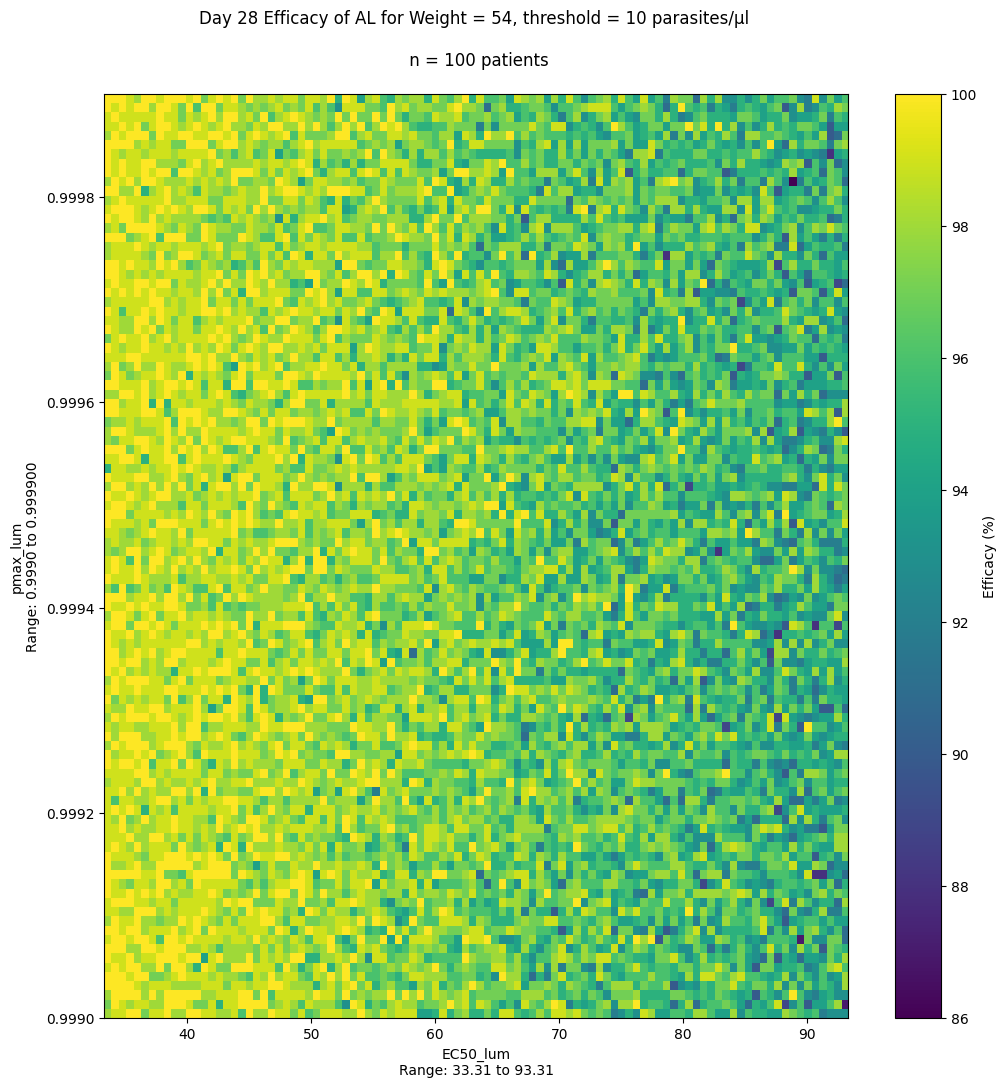

In [ ]:

plt.figure(figsize=(12, 12))

plt.imshow(df_trial_efficacy, extent=(min_ec50, max_ec50, min_pmax, max_pmax), origin='lower', cmap='viridis', aspect = 'auto')

# Create the colorbar
plt.colorbar(label='Efficacy (%)')

# Set the labels and title
plt.xlabel('EC50_lum\nRange: {:.2f} to {:.2f}'.format(min_ec50, max_ec50))
plt.ylabel('pmax_lum\nRange: {:.4f} to {:.6f}'.format(min_pmax, max_pmax))
plt.title('Day 28 Efficacy of AL for Weight = 54, threshold = 10 parasites/μl \n\n n = 500 patients\n')

experiment = "03"
folder = f"AL_calibration_heatmap_results_{experiment}"
#Save plot
plt.savefig(f"{folder}/AL_calibration_heatmap_results_{experiment}.png")
# Show the plot
plt.show()

In [6]:
for i in range(len(ec50_values)):
    for j in range(len(pmax_values)):
        print(f"EC50: {ec50_values[i]:.2f}, pmax: {pmax_values[j]:.6f}, Efficacy: {df_trial_efficacy.iloc[i, j]:.2f}%")
    #Save in one text file
        with open(f"{folder}/artemether_monotherapy_calibration_heatmap_{experiment}_results.txt", "a") as f:
            f.write(f"EC50: {ec50_values[i]:.2f}, pmax: {pmax_values[j]:.6f}, Efficacy: {df_trial_efficacy.iloc[i, j]:.2f}%\n")
    # Save in one dataframe and then save as csv
df_results = pd.DataFrame({
    'EC50_artemether': np.repeat(ec50_values, len(pmax_values)),
    'pmax_artemether': np.tile(pmax_values, len(ec50_values)),
    'Efficacy': df_trial_efficacy.values.flatten()
})
df_results.to_csv(f"{folder}/AL_calibration_heatmap_results_{experiment}_results.csv", index=False)

EC50: 33.31, pmax: 0.999000, Efficacy: 98.00%
EC50: 33.31, pmax: 0.999009, Efficacy: 99.00%
EC50: 33.31, pmax: 0.999018, Efficacy: 99.00%
EC50: 33.31, pmax: 0.999027, Efficacy: 100.00%
EC50: 33.31, pmax: 0.999036, Efficacy: 100.00%
EC50: 33.31, pmax: 0.999045, Efficacy: 97.00%
EC50: 33.31, pmax: 0.999055, Efficacy: 99.00%
EC50: 33.31, pmax: 0.999064, Efficacy: 99.00%
EC50: 33.31, pmax: 0.999073, Efficacy: 100.00%
EC50: 33.31, pmax: 0.999082, Efficacy: 98.00%
EC50: 33.31, pmax: 0.999091, Efficacy: 98.00%
EC50: 33.31, pmax: 0.999100, Efficacy: 100.00%
EC50: 33.31, pmax: 0.999109, Efficacy: 100.00%
EC50: 33.31, pmax: 0.999118, Efficacy: 99.00%
EC50: 33.31, pmax: 0.999127, Efficacy: 99.00%
EC50: 33.31, pmax: 0.999136, Efficacy: 98.00%
EC50: 33.31, pmax: 0.999145, Efficacy: 98.00%
EC50: 33.31, pmax: 0.999155, Efficacy: 99.00%
EC50: 33.31, pmax: 0.999164, Efficacy: 96.00%
EC50: 33.31, pmax: 0.999173, Efficacy: 100.00%
EC50: 33.31, pmax: 0.999182, Efficacy: 98.00%
EC50: 33.31, pmax: 0.999191,

In [14]:
filtered_results = df_results[(df_results['Efficacy'] >= 92.0) & (df_results['Efficacy'] < 93.0)]
filtered_results

,EC50_artemether,pmax_artemether,Efficacy
68,33.310000,0.999618,92.0
96,33.310000,0.999873,92.0
162,33.916061,0.999564,92.0
295,34.522121,0.999864,92.0
366,35.128182,0.999600,92.0
...,...,...,...
9881,92.703939,0.999736,92.0
9884,92.703939,0.999764,92.0
9894,92.703939,0.999855,92.0
9975,93.310000,0.999682,92.0


<br>

# It seems like the 'default' ```pmax_lum``` and ```ec50_lum``` give an efficacy of 96.5% with ```pmax_artemether``` = 0.9998653531
## Checking if it is indeed the case

<br>

In [45]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "5000",
        "--weight", str(weight),
        "--pmax_artemether", "0.9998653531",
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

In [46]:
# Define the weight values to use
#weight_values = [10, 15, 20, 30, 40, 50]
weight_values = [54]

# File suffix for saving results
experiment = "01"
file_suffix = f"AL_calibration_adjusted_{experiment}"

for weight in weight_values:

        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg_{file_suffix}.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg_{file_suffix}.csv", index=False)

        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-06-06 

Length of simulation:  0:02:07.029893 


The failed treatment count for weight 54kg is: 168

The percentage efficacy for weight 54kg is: 96.64 



<br>

# Time to vary ```ec50_lum``` to get an efficacy of 96.5%
## The curve we obtain can be used to obtain other target efficacies

### Experiment Number: 04

In [50]:
# Setting min and max values for EC50_artemether and pmax_artemether
min_ec50 = 1
max_ec50 = 500

# Define the range for EC50 and pmax
ec50_values = np.linspace(min_ec50, max_ec50, 101)

#Saving EC50_artemether and pmax_artemether range for future reference
experiment = "04"
folder = f"AL_calibration_pmax_lum_vs_efficacy_results_{experiment}"
os.makedirs(folder, exist_ok=True) 

np.savetxt(f'{folder}/AL_calibration_ec50_lum_range_{experiment}.txt', ec50_values, delimiter=',', fmt='%5f')

# Initialize a grid to store the clearance rates
efficacy_values = np.zeros(len(ec50_values))
failed_treatment_count_values = np.zeros(len(ec50_values))

print(ec50_values)

[  1.     5.99  10.98  15.97  20.96  25.95  30.94  35.93  40.92  45.91
  50.9   55.89  60.88  65.87  70.86  75.85  80.84  85.83  90.82  95.81
 100.8  105.79 110.78 115.77 120.76 125.75 130.74 135.73 140.72 145.71
 150.7  155.69 160.68 165.67 170.66 175.65 180.64 185.63 190.62 195.61
 200.6  205.59 210.58 215.57 220.56 225.55 230.54 235.53 240.52 245.51
 250.5  255.49 260.48 265.47 270.46 275.45 280.44 285.43 290.42 295.41
 300.4  305.39 310.38 315.37 320.36 325.35 330.34 335.33 340.32 345.31
 350.3  355.29 360.28 365.27 370.26 375.25 380.24 385.23 390.22 395.21
 400.2  405.19 410.18 415.17 420.16 425.15 430.14 435.13 440.12 445.11
 450.1  455.09 460.08 465.07 470.06 475.05 480.04 485.03 490.02 495.01
 500.  ]


In [51]:
def run_simulation_ec50_lum_adj(idx, ec50_lum, n_patients):
    command_ec50_lum = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", str(n_patients),
        "--weight", "54",
        "--pmax_artemether", "0.9998653531",
        "--ec50_lum", str(ec50_lum),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_ec50_lum = subprocess.run(command_ec50_lum, capture_output=True, text=True, check=True)

        # Process the output
        lines_ec50_lum = output_ec50_lum.stdout.splitlines()
        df_ec50_lum = pd.DataFrame(
            [line.split() for line in lines_ec50_lum],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_ec50_lum = df_ec50_lum.iloc[1:].apply(pd.to_numeric, errors='coerce')

        experiment = "04"
        folder = f"AL_calibration_pmax_lum_vs_efficacy_results_{experiment}"
        os.makedirs(folder, exist_ok=True) 

        # Saving the Dataframe as a CSV file 
        filepath = f"{folder}/AL_calibration_pmax_lum_vs_efficacy_results_{experiment}_{ec50_lum:.2f}.csv"
        df_ec50_lum.to_csv(filepath, index=False)

        # Calculate the efficacy
        failed_treatment_count = df_ec50_lum[df_ec50_lum['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_ec50_lum['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        filepath = f"{folder}/AL_calibration_pmax_lum_vs_efficacy_results_{experiment}_{ec50_lum:.2f}.txt"

        with open(filepath, "w") as f:
            f.write(f"EC50_lum: {ec50_lum}, Failed treatment count: {failed_treatment_count}\n")

        return (idx, efficacy, df_ec50_lum)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for ec50_lum: {ec50_lum}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for ec50_lum: {ec50_lum}: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [53]:

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()


n_patients = 10000  # Number of patients for each simulation
experiment = "04"
file_suffix = f"calibration_ec50_lum_adjusted_{experiment}"
folder = f"AL_calibration_pmax_lum_vs_efficacy_results_{experiment}"

# Prepare a list of parameters to pass to the pool
params_list = [(i, ec50_values[i], n_patients) for i in range(len(ec50_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_ec50_lum_adj, params_list):
            idx, efficacy, df_ec50_lum = result
            results.append((idx, efficacy, df_ec50_lum))
            if df_ec50_lum is not None:
                dfs.append(df_ec50_lum)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_ec50_lum in results:
    efficacy_values[idx] = efficacy

# Create a DataFrame with  and clearance_rates
df = pd.DataFrame({
    'ec50_lum': ec50_values,
    'efficacy': efficacy_values
})

# Save the DataFrame to a pickle file
df.to_pickle(f"{folder}/pkpd_AL_{file_suffix}.pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle(f"{folder}/pkpd_AL_{file_suffix}.pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv(f"{folder}/pkpd_AL_{file_suffix}.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 101/101 [53:06<00:00, 31.55s/it]   

DataFrame saved as pickle and CSV files successfully.


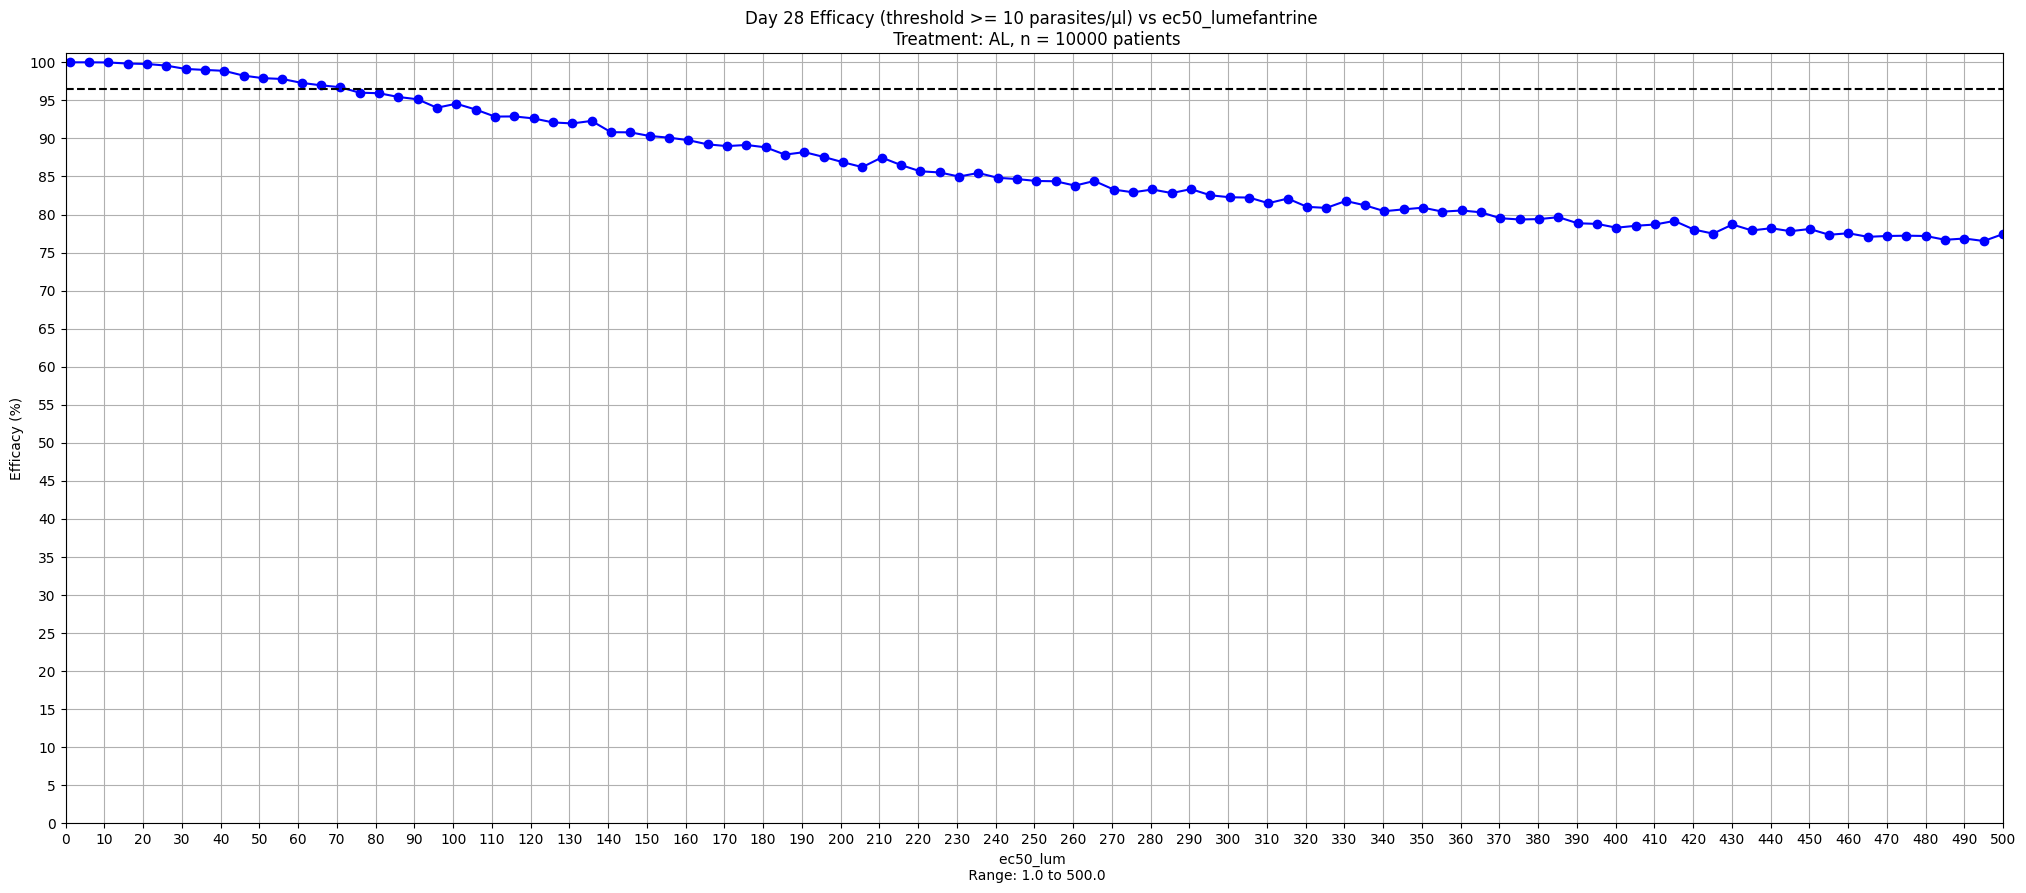

In [82]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(ec50_values, efficacy_values, marker='o', linestyle='-', color='b')
plt.xlabel(f'ec50_lum \n Range: {min(ec50_values)} to {max(ec50_values)}')
plt.ylabel('Efficacy (%)')
plt.title(f"Day 28 Efficacy (threshold >= 10 parasites/μl) vs ec50_lumefantrine \n Treatment: AL, n = {n_patients} patients")
plt.grid(True)
plt.xlim(min(ec50_values), max(ec50_values))  # Set x-axis limits
plt.xticks(np.arange(0, max(ec50_values)+10,10))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=96.5, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig(f"pkpd_AL_{file_suffix}.png")  # Save the plot as a PNG file
plt.show()